In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

%run utility_functions.py # functions reused throughout

-1    4849
 1    1001
Name: cleave, dtype: int64

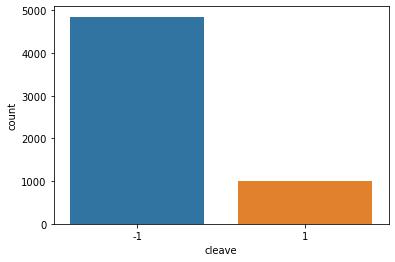

In [2]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)
# skewed toward predicting negative because more examples?

In [3]:
# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

from imblearn.under_sampling import RandomUnderSampler
#https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
# add undersampling of majority class to improve performance.
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)


In [4]:

clf = svm.SVC(random_state=0)


parameters = {'kernel': ['linear', 'rbf'],
              'gamma': ['scale', 'auto'],
              'C': [1, 10, 100],
              'shrinking': [True, False],
              'break_ties': [True, False],
              'tol': [1e-3, 1e-4],
              'max_iter': [1000, 5000, 10000, 20000],
              'probability': [True]
             }


# scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_
clf.get_params()

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 100,
 'break_ties': True,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': 20000,
 'probability': True,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [5]:
# train model
clf.fit(x_train, y_train)

c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=100, break_ties=True, gamma='auto', max_iter=20000, probability=True,
    random_state=0)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.688


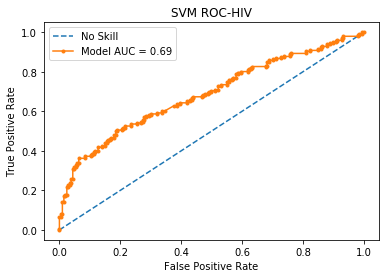

Model: f1=0.619 auc=0.717


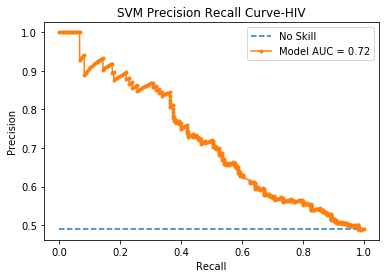

Classification Report
              precision    recall  f1-score   support

          -1       0.64      0.65      0.64       205
           1       0.62      0.61      0.62       196

    accuracy                           0.63       401
   macro avg       0.63      0.63      0.63       401
weighted avg       0.63      0.63      0.63       401

Confusion Matrix
[[133  72]
 [ 76 120]]


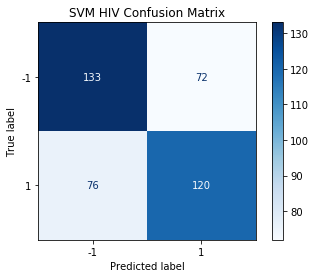

<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

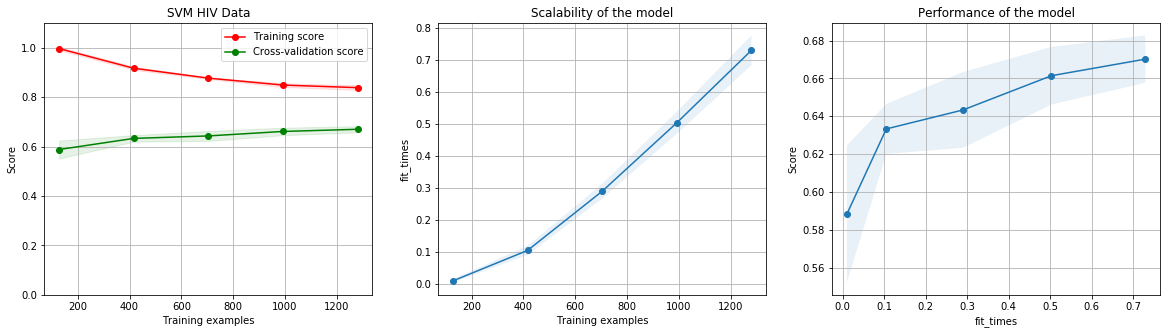

In [6]:

# filter warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'SVM ROC-HIV')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'SVM Precision Recall Curve-HIV')

# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels=['-1', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
cm.ax_.set_title('SVM HIV Confusion Matrix')
plt.savefig('../images/cm_SVM_HIV.png')
plt.show()

#print('Accuracy')
#print(accuracy_score(y_test, y_predict))

# for unbalanced data
#print('Balanced Accuracy')
#print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "SVM HIV Data", x_train, y_train, ylim=[0,1.1])


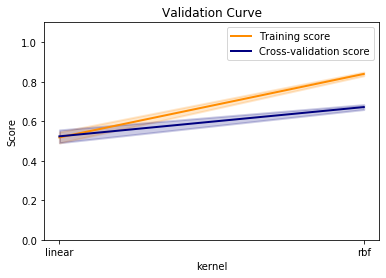

In [7]:
plot_model_complexity_analysis(clf, 'kernel', ['linear', 'rbf'], 'SVM_HIV', x_train, y_train)

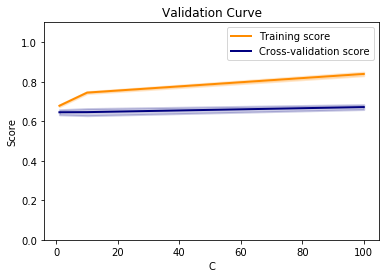

In [8]:
plot_model_complexity_analysis(clf, 'C', [1, 10, 100], 'SVM_HIV', x_train, y_train)

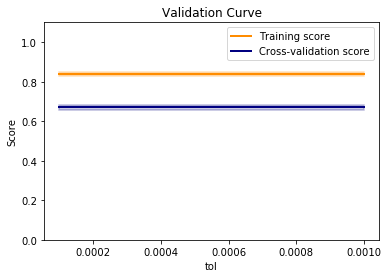

In [9]:
plot_model_complexity_analysis(clf, 'tol', [1e-3, 1e-4],'SVM_HIV', x_train, y_train)

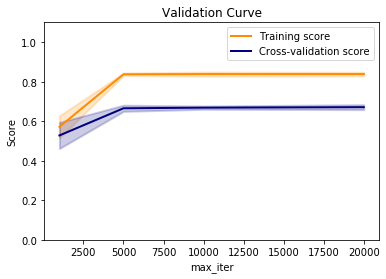

In [10]:

plot_model_complexity_analysis(clf, 'max_iter', [1000, 5000, 10000, 20000],'SVM_HIV', x_train, y_train)